In [2]:
pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 23.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier #if numerical use regresssor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import export_text


Colab environment detected.


In [4]:
# Load the data
ebay_data = dmba.load_data('eBayAuctions.csv')


In [5]:
# Preprocess the data
ebay_data['endDay'] = ebay_data['endDay'].astype(pd.CategoricalDtype())
ebay_data['endDay'] = ebay_data['endDay'].cat.codes

ebay_data['Category'] = ebay_data['Category'].astype(pd.CategoricalDtype())
ebay_data['Category'] = ebay_data['Category'].cat.codes

ebay_data['Duration'] = ebay_data['Duration'].astype(pd.CategoricalDtype())
ebay_data['Duration'] = ebay_data['Duration'].cat.codes

ebay_data['currency'] = ebay_data['currency'].astype(pd.CategoricalDtype())
ebay_data['currency'] = ebay_data['currency'].cat.codes

In [6]:
X = ebay_data.drop(columns=['Competitive?'])
y = ebay_data['Competitive?']

In [7]:
# Preprocessing
# 40% validation data
# Slpit the data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size= 0.4, random_state= 1)

In [8]:
# Fit a classification tree using all predictors, using the best-pruned tree. To avoid overfitting,
# set the minimum number of records in a terminal node to 50. Also set the maximum number of levels to be displayed at seven (the maximum allowed in XLMiner).

smallClassTree = DecisionTreeClassifier(criterion='gini',max_depth=7, min_samples_split=50) # if
smallClassTree.fit(train_X, train_y)


DecisionTreeClassifier(max_depth=7, min_samples_split=50)

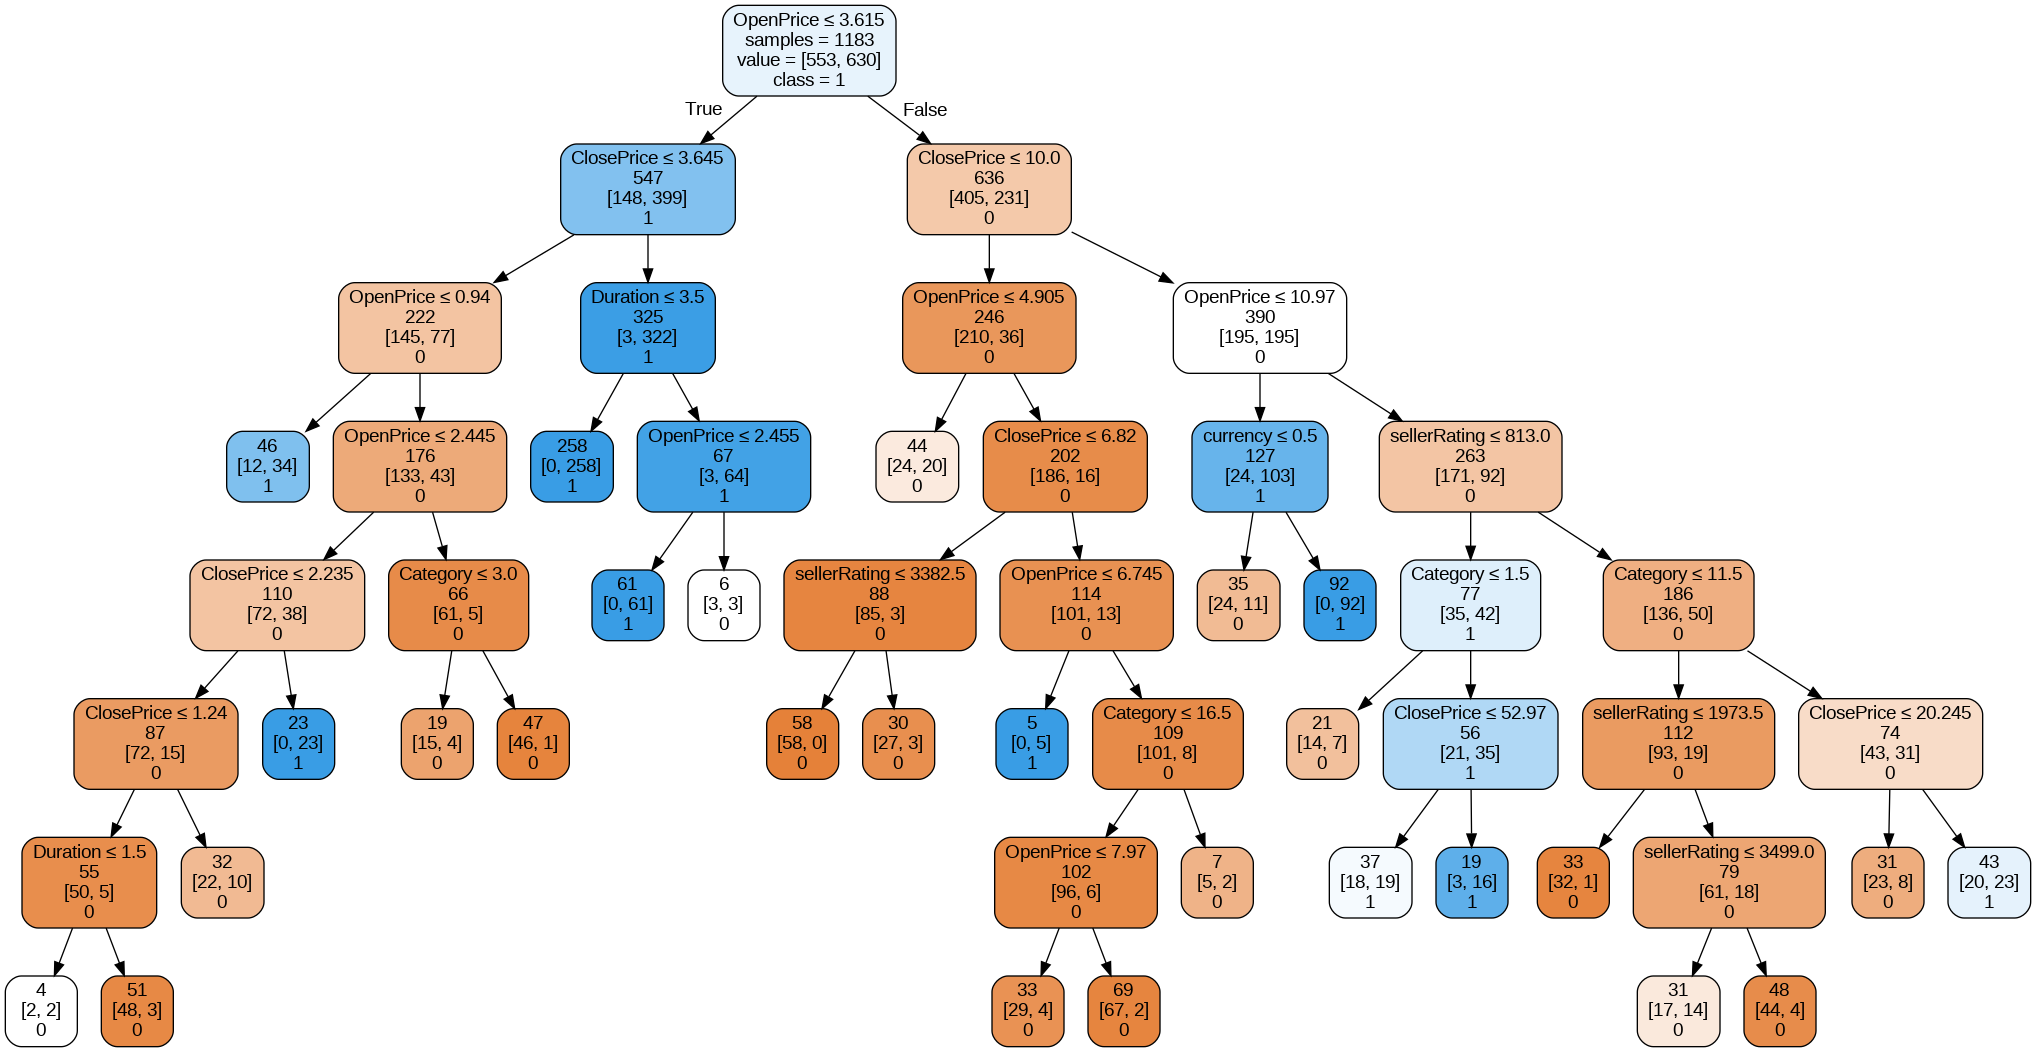

In [9]:
# Plot the tree to visualize the best-pruned tree

plotDecisionTree(smallClassTree, feature_names=train_X.columns, class_names=smallClassTree.classes_)

In [10]:
# Extract rules
tree_rules = export_text(smallClassTree, feature_names=train_X.columns)
print(tree_rules)

|--- OpenPrice <= 3.62
|   |--- ClosePrice <= 3.64
|   |   |--- OpenPrice <= 0.94
|   |   |   |--- class: 1
|   |   |--- OpenPrice >  0.94
|   |   |   |--- OpenPrice <= 2.45
|   |   |   |   |--- ClosePrice <= 2.24
|   |   |   |   |   |--- ClosePrice <= 1.24
|   |   |   |   |   |   |--- Duration <= 1.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Duration >  1.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- ClosePrice >  1.24
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- ClosePrice >  2.24
|   |   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  2.45
|   |   |   |   |--- Category <= 3.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Category >  3.00
|   |   |   |   |   |--- class: 0
|   |--- ClosePrice >  3.64
|   |   |--- Duration <= 3.50
|   |   |   |--- class: 1
|   |   |--- Duration >  3.50
|   |   |   |--- OpenPrice <= 2.46
|   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  2.46
|   |   |   |   |

In [11]:
# Make predictions
# Evaluate the model
# The Accuaracy Score before Removing the varibales
print("Classification Tree Model Performance:\n")

print(f"Confusion Matrix for Train data set:\n")
classificationSummary(train_y, smallClassTree.predict(train_X))

print(f"\nConfusion Matrix for validation set:\n")
classificationSummary(valid_y, smallClassTree.predict(valid_X))



Classification Tree Model Performance:

Confusion Matrix for Train data set:

Confusion Matrix (Accuracy 0.8715)

       Prediction
Actual   0   1
     0 500  53
     1  99 531

Confusion Matrix for validation set:

Confusion Matrix (Accuracy 0.8340)

       Prediction
Actual   0   1
     0 309  44
     1  87 349


In [12]:
# To find Good variables, Calculate performance and errors
# cross-validation of the full decision tree classifier
treeClassifier = DecisionTreeClassifier()
scores = cross_val_score(treeClassifier, train_X, train_y, cv=7)# five folds value is 7
print('Accuracy scores of each fold: ', [acc for acc in scores])
print('Accuracy:', scores.mean())# average accuracy

Accuracy scores of each fold:  [0.8757396449704142, 0.8461538461538461, 0.8994082840236687, 0.8816568047337278, 0.8875739644970414, 0.8875739644970414, 0.9171597633136095]
Accuracy: 0.8850380388841926


        feature  importance
4        endDay    0.000000
3      Duration    0.004230
0      Category    0.024965
2  sellerRating    0.039966
1      currency    0.060865
6     OpenPrice    0.410163
5    ClosePrice    0.459811


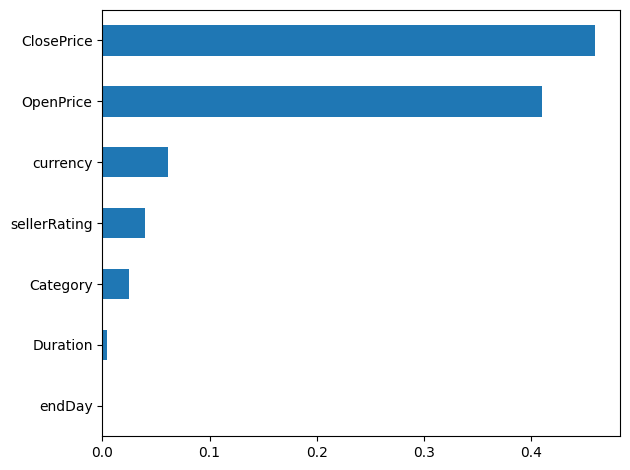

In [13]:
importances = smallClassTree.feature_importances_ # variable importance
df = pd.DataFrame({'feature': train_X.columns, 'importance': importances})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [14]:
# We can remove remaining predictors [currency (0.060865), sellerRating 	(0.039966), Category (0.024965), Duration (0.004230), endDay (0.000000)]
#after validating the impact of removing these variables through model performance metrics (e.g., accuracy, F1-score)
#to confirm that the model's 	performance does not degrade significantly.


good_predictors_X = ebay_data[['ClosePrice','OpenPrice']]

In [15]:
train_good_predict_X, valid_good_predict_X, train_good_predict_y, valid_good_predict_y = train_test_split(good_predictors_X, y, test_size= 0.4, random_state= 1)

In [16]:
modifiedClassTree = DecisionTreeClassifier(criterion='gini',max_depth=7, min_samples_split=50)
modifiedClassTree.fit(train_good_predict_X, train_good_predict_y)

DecisionTreeClassifier(max_depth=7, min_samples_split=50)

In [17]:
# # The Accuaracy Score after Removing the varibales
#  TO REMOVE VARIABLES OR KEEP
classificationSummary(train_good_predict_y, modifiedClassTree.predict(train_good_predict_X)) #confu matrix on trainign and test set, usually accuracy of test will be low because of size given
classificationSummary(valid_good_predict_y, modifiedClassTree.predict(valid_good_predict_X))

Confusion Matrix (Accuracy 0.8740)

       Prediction
Actual   0   1
     0 497  56
     1  93 537
Confusion Matrix (Accuracy 0.8428)

       Prediction
Actual   0   1
     0 318  35
     1  89 347


In [18]:
#D. Fit another classification tree (using the best-pruned tree, with a minimum number of records per terminal node = 50
#and maximum allowed number of  levels are 7), this time only with predictors that can be used for predicting the outcome of a new auction.
#Describe the resulting tree in terms of rules. Make sure to report the smallest set of rules required for classification.

classTreeOnlySamples = DecisionTreeClassifier(min_samples_split=50,max_depth=7)
classTreeOnlySamples.fit(train_good_predict_X, train_good_predict_y)

DecisionTreeClassifier(max_depth=7, min_samples_split=50)

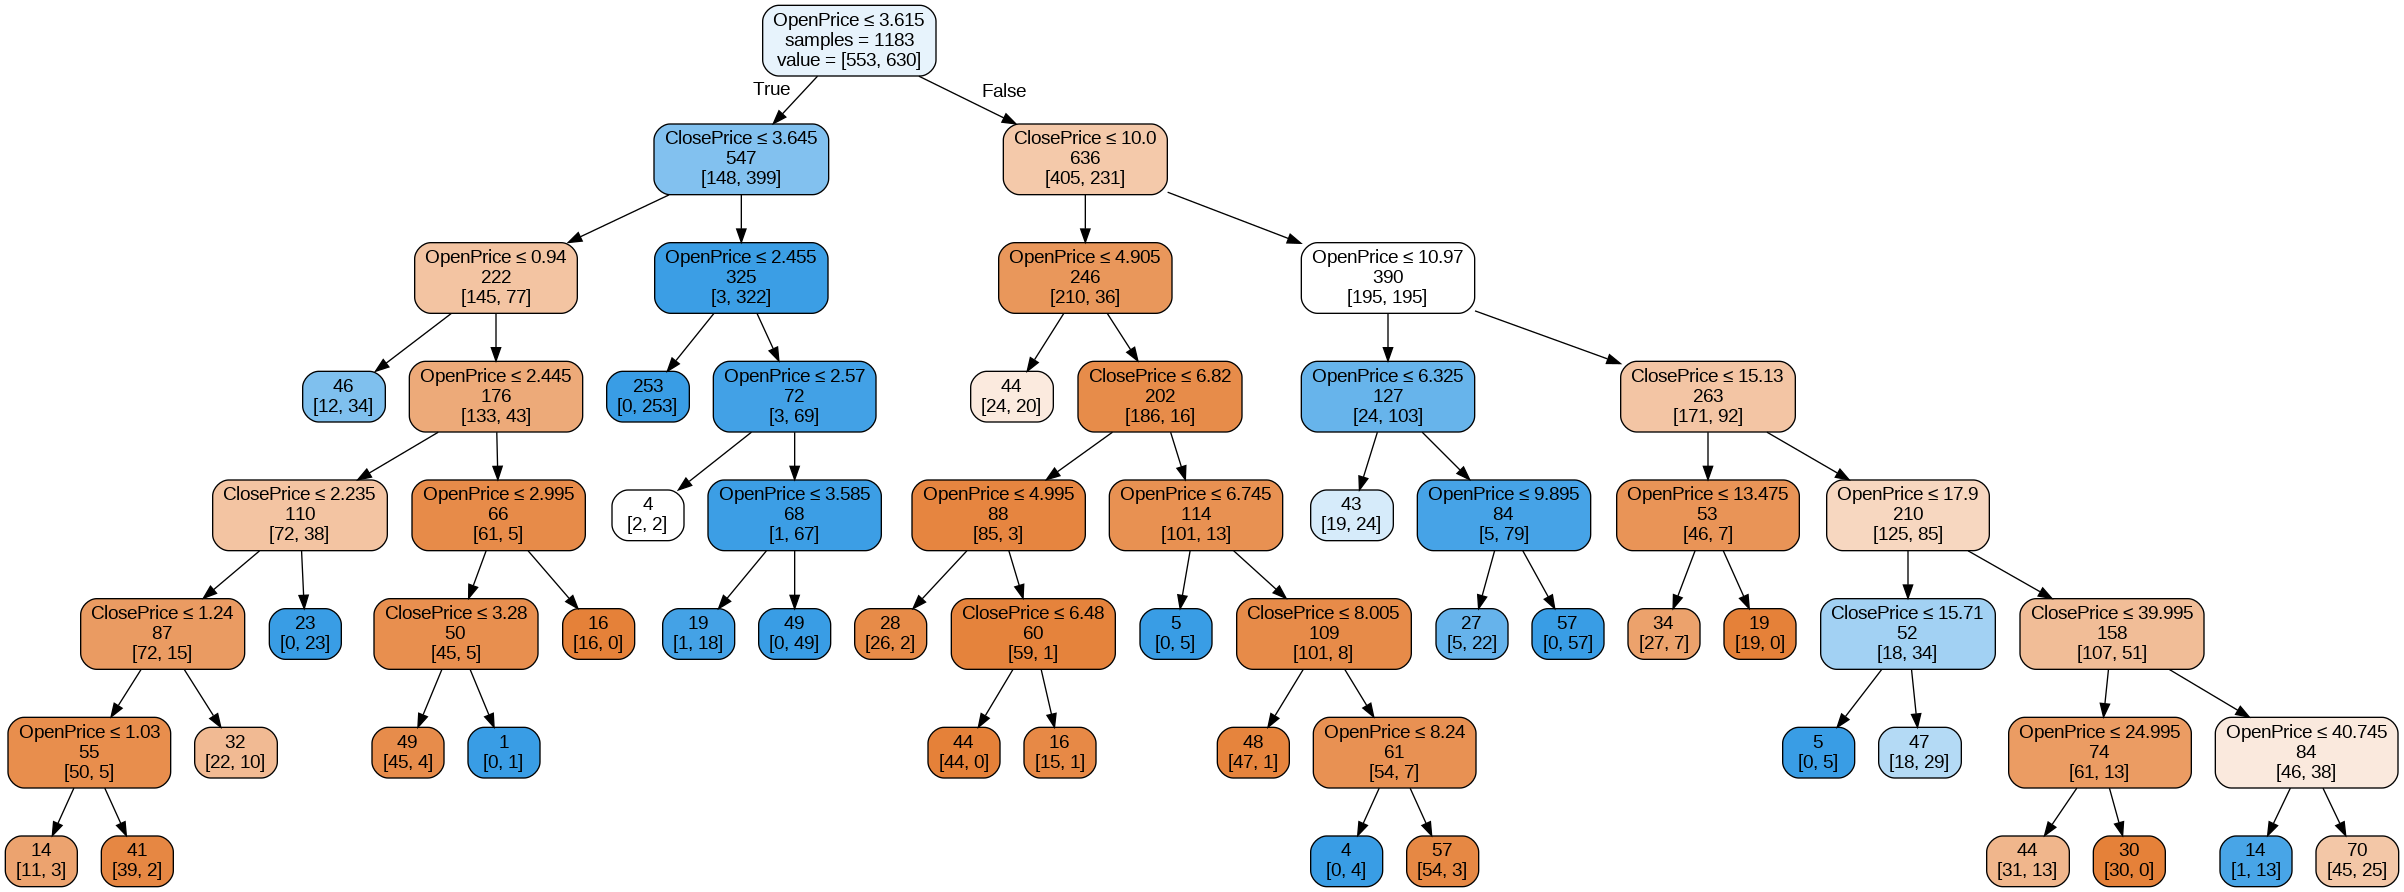

In [ ]:
plotDecisionTree(classTreeOnlySamples, feature_names=train_good_predict_X.columns)

In [19]:
# Extract rules
tree_rules = export_text(classTreeOnlySamples, feature_names=train_good_predict_X.columns)
print(tree_rules)

|--- OpenPrice <= 3.62
|   |--- ClosePrice <= 3.64
|   |   |--- OpenPrice <= 0.94
|   |   |   |--- class: 1
|   |   |--- OpenPrice >  0.94
|   |   |   |--- OpenPrice <= 2.45
|   |   |   |   |--- ClosePrice <= 2.24
|   |   |   |   |   |--- ClosePrice <= 1.24
|   |   |   |   |   |   |--- ClosePrice <= 1.03
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- ClosePrice >  1.03
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- ClosePrice >  1.24
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- ClosePrice >  2.24
|   |   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  2.45
|   |   |   |   |--- OpenPrice <= 3.00
|   |   |   |   |   |--- ClosePrice <= 3.28
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- ClosePrice >  3.28
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- OpenPrice >  3.00
|   |   |   |   |   |--- class: 0
|   |--- ClosePrice >  3.64
|   |   |--- OpenPrice <= 2.46
|   |   |   |--- class: 1
|   |   |-

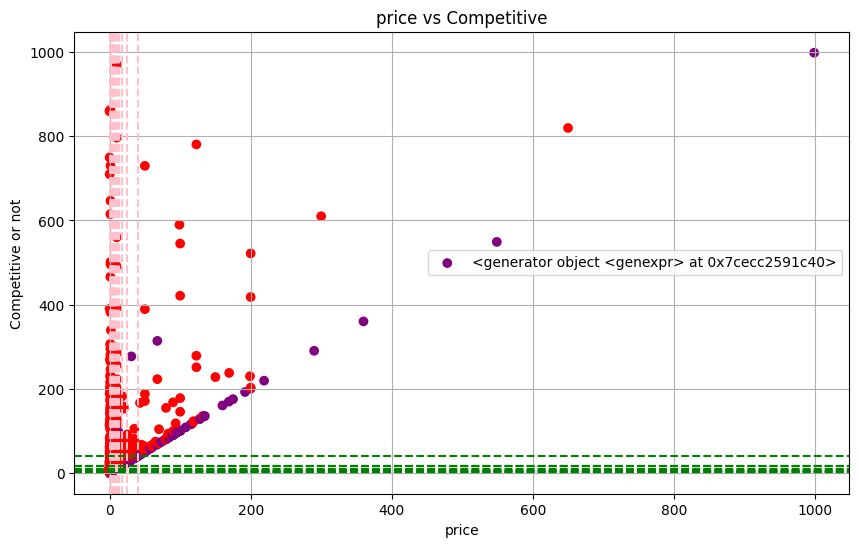

In [20]:
# Unique thresholds from the decision tree rules
open_price_thresholds = [0.94, 2.45, 3.00, 3.62, 4.90, 4.99, 6.33, 6.74, 8.24, 9.89, 10.97, 13.47, 17.90, 24.99, 40.75]
close_price_thresholds = [1.03, 1.24, 2.24, 3.28, 3.64, 6.82, 10.00, 15.13, 15.68, 15.71, 40.00]


plt.figure(figsize=(10, 6))
colors = {1: 'red', 0: 'purple'}
label = {1: 'Competitive', 0: 'non-competitive'}
plt.scatter(ebay_data['OpenPrice'], ebay_data['ClosePrice'], c=ebay_data['Competitive?'].apply(lambda x: colors[x]),label=(y for y in label))

# Draw vertical lines for OpenPrice thresholds
for threshold in open_price_thresholds:
    plt.axvline(x=threshold, color='pink', linestyle='--')

# Draw horizontal lines for ClosePrice thresholds
for threshold in close_price_thresholds:
    plt.axhline(y=threshold, color='green', linestyle='--')

plt.title('price vs Competitive')
plt.xlabel('price')
plt.ylabel('Competitive or not')

# Add a legend for the classes


plt.legend()

plt.grid(True)
plt.show()

In [ ]:
# F. Examine the lift chart and the classification table for the tree.
# What can you say about the predictive performance of this model?
classificationSummary(train_good_predict_y, modifiedClassTree.predict(train_good_predict_X)) #confu matrix on trainign and test set, usually accuracy of test will be low because of size given
classificationSummary(valid_good_predict_y, modifiedClassTree.predict(valid_good_predict_X))

Confusion Matrix (Accuracy 0.8740)

       Prediction
Actual   0   1
     0 497  56
     1  93 537
Confusion Matrix (Accuracy 0.8428)

       Prediction
Actual   0   1
     0 318  35
     1  89 347


In [ ]:
#G. Based on this last tree, what can you conclude from these data about the chances of an auction obtaining at least two bids
# and its relationship to the auction settings set by the seller (duration, opening price, ending day, currency)?
# What would you recommend for a seller as the strategy that will most likely lead to a competitive auction?



from sklearn.preprocessing import LabelEncoder